In [1]:
import datetime
import os
import sys
import random
import math
import re
import time
import numpy as np


import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
import skimage


ROOT_DIR = os.path.abspath("../..")

In [2]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from samples.face import face
from samples.face import utils as face_utils

%matplotlib inline

/home/jho/anaconda3/envs/maskrcnn-tf10-py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jho/anaconda3/envs/maskrcnn-tf10-py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jho/anaconda3/envs/maskrcnn-tf10-py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jho/anaconda3

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/weights")

LOG_DIR = os.path.join(ROOT_DIR, 'logs/')

## Configurations

Configurations are defined in face.py

## Load weights

In [4]:
config = face.FaceConfig()
FACE_DIR = os.path.join(ROOT_DIR, "samples/face/face_data")

class InferenceConfig(face.FaceConfig):
    # Set batch size to 1
    GPU_COUNT = 1
    IMAGES_PER_GPU =1

inference_config = InferenceConfig()
# inference_config.display()

model = modellib.MaskRCNN(mode="inference", config=inference_config,
                          model_dir=MODEL_DIR)
# weights_path = model.find_last()
# weights_path = os.path.join(MODEL_DIR, "face/coco/face_epochs1000.h5")
weights_path = os.path.join(MODEL_DIR, "face_epochs10(5)_steps3200_resize512/mask_rcnn_face_0009.h5")
tag = 'epochs2(1)_steps3200_resize512'
model.load_weights(weights_path, by_name=True)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Blur Face

In [5]:
import cv2

def blur_face(image, mask):
    """Apply blurring on face.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a blur copy of the image. The grayscale copy still
    # has 3 RGB channels, though.


    blur = cv2.blur(image, (10, 128))
    # gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        blurred = np.where(mask, blur, image).astype(np.uint8)
    else:
        blurred = blur.astype(np.uint8)
    return blurred

def detect_face_and_blur(model, image_path=None, video_path=None, tag=None):
    assert image_path or video_path

    
    
    # Image or video?
    if image_path:
        image_name = image_path.split('/')[-1].split('.')[0]
        if tag is not None:
            image_name += "_{}".format(tag)
        # Run model detection and generate the color splash effect
        print("Running on {}".format(image_path))
        # Read image
        image = skimage.io.imread(image_path)
        original_path = "{}/original_{}_{:%Y%m%dT%H%M%S}.png".format(os.path.join(LOG_DIR, 'images/face'), image_name, datetime.datetime.now())
        skimage.io.imsave(original_path, image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = blur_face(image, r['masks'])
        # Save output
        file_name = "{}/blur_{}_{:%Y%m%dT%H%M%S}.png".format(os.path.join(LOG_DIR, 'images/face'), image_name, datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        
        # Video capture
        video_name = video_path.split('/')[-1].split('.')[0]
        if tag is not None:
            video_name += "_{}".format(tag)
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "{}/blur_{}_{:%Y%m%dT%H%M%S}.avi".format(os.path.join(LOG_DIR, 'videos/face'), video_name, datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = blur_face(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

    return file_name

In [6]:
img_path = os.path.join(ROOT_DIR, 'samples/face/sample_img5.jpg')
if not os.path.exists(img_path):
    raise FileNotFoundError


blurred_img_path =detect_face_and_blur(model, image_path=img_path, video_path=None, tag=tag)

# splashed_img_path = face.detect_and_color_splash(model, image_path=img_path, video_path=None)

Running on /home/jho/projects/Mask_RCNN/samples/face/sample_img5.jpg
Processing 1 images
image                    shape: (169, 299, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  299.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
Saved to  /home/jho/projects/Mask_RCNN/logs/images/face/blur_sample_img5_epochs2(1)_steps3200_resize512_20200410T155249.png


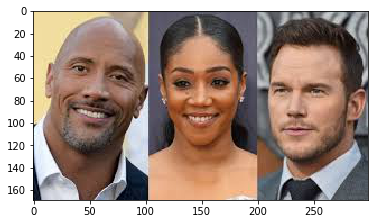

In [7]:
original_img_array = face.open_image_as_nparray(img_path)
plt.imshow(original_img_array)


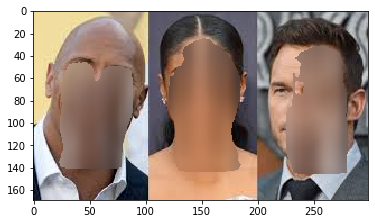

In [8]:
splashed_img_array = face.open_image_as_nparray(blurred_img_path)
plt.imshow(splashed_img_array)

In [9]:
video_path = os.path.join(ROOT_DIR, 'samples/face/sample_data/recorded_video03.mkv')
if not os.path.exists(video_path):
    raise FileNotFoundError
    
blurred_video_path =detect_face_and_blur(model, image_path=None, video_path=video_path, tag=tag)

frame:  0
frame:  1
frame:  2
frame:  3
frame:  4
frame:  5
frame:  6
frame:  7
frame:  8
frame:  9
frame:  10
frame:  11
frame:  12
frame:  13
frame:  14
frame:  15
frame:  16
frame:  17
frame:  18
frame:  19
frame:  20
frame:  21
frame:  22
frame:  23
frame:  24
frame:  25
frame:  26
frame:  27
frame:  28
frame:  29
frame:  30
frame:  31
frame:  32
frame:  33
frame:  34
frame:  35
frame:  36
frame:  37
frame:  38
frame:  39
frame:  40
frame:  41
frame:  42
frame:  43
frame:  44
frame:  45
frame:  46
frame:  47
frame:  48
frame:  49
frame:  50
frame:  51
frame:  52
frame:  53
frame:  54
frame:  55
frame:  56
frame:  57
frame:  58
frame:  59
frame:  60
frame:  61
frame:  62
frame:  63
frame:  64
frame:  65
frame:  66
frame:  67
frame:  68
frame:  69
frame:  70
frame:  71
frame:  72
frame:  73
frame:  74
frame:  75
frame:  76
frame:  77
frame:  78
frame:  79
frame:  80
frame:  81
frame:  82
frame:  83
frame:  84
frame:  85
frame:  86
frame:  87
frame:  88
frame:  89
frame:  90
frame:  9

In [10]:
def blur_realtime(model, video_path=None):
# Video capture
      
    cap = cv2.VideoCapture(0)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(width, height, fps)
    
    
    count = 0
    success = True
    if True:
        success, frame = cap.read()
        
        preview = plt.imshow(face_utils.open_image_as_nparray(frame))
    while success:
        try:
            # print("frame: ", count)
            # Read next image
            success, frame = cap.read()

            if success:
                # OpenCV returns images as BGR, convert to RGB
                frame = frame[..., ::-1]
                # Detect objects
                r = model.detect([frame], verbose=0)[0]
                # Color splash

                blurred = blur_face(frame, r['masks'])
                # RGB -> BGR to save image to video
                blurred = blurred[..., ::-1]
                # Show
                count += 1
                preview.set_data(frame)
                plt.draw()



            # k = cv2.waitKey(1) & 0xff
            # if k == 27:
            #     break
            if count > 100:
                break
        except KeyboardInterrupt:
            cap.release()
            # cv2.destroyAllWindows()
   
def blur_once(model, video_path=None):
# Video capture
      
    cap = cv2.VideoCapture(0)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(width, height, fps)
    
    
    count = 0
    success = True
    

    # print("frame: ", count)
    # Read next image
    success, frame = cap.read()

    if success:
        # OpenCV returns images as BGR, convert to RGB
        frame = frame[..., ::-1]
        # Detect objects
        r = model.detect([frame], verbose=0)[0]
        # Color splash

        blurred = blur_face(frame, r['masks'])
        # RGB -> BGR to save image to video
        blurred = blurred[..., ::-1]
        # Show

        plt.imshow(face_utils.open_image_as_nparray(frame))



640 480 30.0


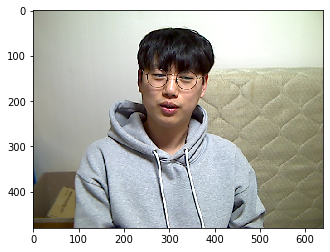

In [13]:
blur_once(model)

640 480 30.0


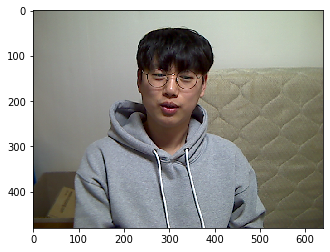

In [12]:
blur_realtime(model)